## Load things

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')


from ipywidgets import interact
import os,sys
# sys.addaudithook
rpath = os.getcwd()
sys.path.insert(0,"../")
# import utils

import dimred ### library of dimension reduction

In [2]:
from dimred.data.loader import LoadOne
from dimred.data.preprocess import MinMaxScalar,ZeroMeanScalar,MeanMaxScalar
# dimred.
from dimred.data.preprocess import scale_sanity,Scalar

from dimred.models.linear.transform import Kurtosis
from dimred.models.linear.transform import co_variance,co_kurtosis
from dimred.tester.plotting import plot_embedding,plot_compare
from dimred.tester.metrics import mean_sq_error,mean_abs_error


## Read data

In [3]:
loader = LoadOne()

In [8]:
# domains = (1,4)

# xrig = loader.getDomain(domains)
# loader.plotImg(spec=12)

reading file autoignition.1.0000E-05.field.mpi...


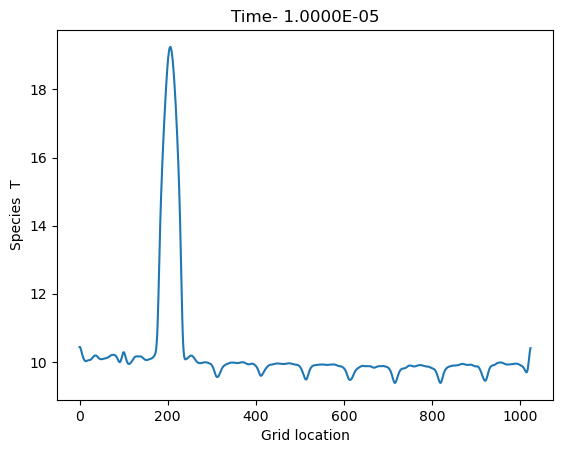

In [4]:
time_step = 100

xrig = loader.getTime(time_step,verbose=3)[:,:14]
loader.plotLine(spec=12,time=time_step)

## Dim reduction

 Transformation

- xreduced is 4D vector:
- project back to original space
- Low rank newly reconstructed matrix

In [5]:
def transform_step(xinput,retain=4,plots=True,verbose=2,moment=co_kurtosis,scalar=AvgMaxScalar):
    xrig = xinput.copy()    
    ## Reading and scaling data:-->
    xold = xrig.copy()
    if verbose>0:
        print("Orignial data")
        scale_sanity(xrig)
    slr = Scalar(scalar)
    slr.fit(xrig)
    xscaled = slr.transform(xrig) #scale_sanity(xscaled)
    
    ## Moment calculation: -->
    clf = Kurtosis(n_retain=retain)
    clf.fit(xscaled,moment=moment)  ## or co_variance; user inputx
    xred = clf.transform(xscaled)

    plot_embedding(xred,titler="co_kurtosis_space",color_spec=xscaled[:,10],cmap="jet")
    
    ## linear reconstruction:-->
    xpew = clf.transform2(xred)
    ## xred is x reduced| et voila
    xnew = slr.transform2(xpew)
    err = mean_sq_error(xnew,xold)
    
    ## plotting and results: -->
#     if plots:
#         plot_compare(xold,xnew)
    
    if verbose>1:
        print("Reconstructed data")
        scale_sanity(xnew)
    
    print(f"Error in reconstruction after retaining {retain} vectors is {err:.4f}")
    return err,xold,xnew

Xnew is transformed data

Xold is original data

## Source Term comparison 

In [6]:
import cantera as ct
syngas = ct.Solution('cantera-module/COH2.cti')

indices = {'temp':12,'press':13}
references = {'press':1.41837E+05,'temp':120} ## same keys


In [44]:
# MFID is Mass fraction index in data; Samul L Jacksons MF
# NVR is Num of variables to retain; ignore velocity components

In [7]:
def cantera_step(xinput,NVR=14,MFID=12,indices=indices,references=references,gas=syngas,verbose=2):
    
    nvs = xinput.shape[-1]  ## reshapeing to oned array for cantera
    xinp = xinput.reshape(-1,nvs)
    
    nx,nvs = xinp.shape
    xinp = xinp[:,:NVR]

    ref_array = np.ones(NVR) #reference values required for conversion into the SI units
    for k,v in indices.items():
        ref_array[v] = references[k]

    if verbose:   ## print gas properties
        print(gas())

    ## below are hardcoded numbers --- TBD

    prod_rates = []
    react_rates = []
    for i in range(nx):                                  #iterating over all grid points
    #     print(i)                                            
        sample = xinp[i]*ref_array                 #converting into the SI units
        gas.Y = sample[:MFID]                                #setting up the mass fraction of the species
        gas.TP = sample[MFID:NVR]                             #setting up the temperature and pressure of gas
        prod_rates.append(gas.net_production_rates)      #calculating production/consumption rates
        react_rates.append(gas.net_rates_of_progress)    #calculating reaction rates
    return np.array(prod_rates),np.array(react_rates)

## Final calculation

Orignial data
Maxima is 19.25 
 Minima is 0.00 
 (1024, 14)
Reconstructed data
Maxima is 18.32 
 Minima is -0.02 
 (1024, 14)
Error in reconstruction after retaining 4 vectors is 0.0045


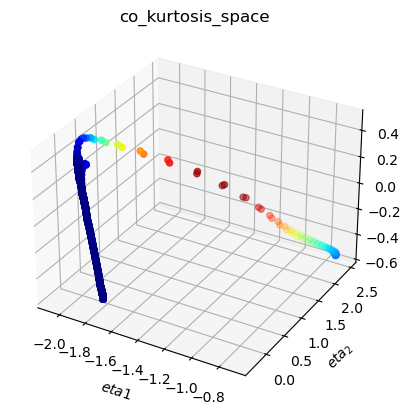

In [8]:
err,xold,xnew = transform_step(xrig,moment=co_variance)

In [9]:
prod_new,react_new = cantera_step(xnew,verbose=0) 
prod_old,react_old = cantera_step(xold)


  gas:

       temperature   1159 K
          pressure   4.2064e+05 Pa
           density   1.1174 kg/m^3
  mean mol. weight   25.599 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy        2.5296e+05        6.4756e+06  J
   internal energy       -1.2348e+05        -3.161e+06  J
           entropy            8893.2        2.2766e+05  J/K
    Gibbs function       -1.0054e+07       -2.5739e+08  J
 heat capacity c_p            1312.5             33600  J/K
 heat capacity c_v            987.74             25285  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                H2         0.0085862           0.10903           -18.664
                O2           0.18544           0.14836           -27.458
                 O        0.00069756         0.0011161          -0.45124
 

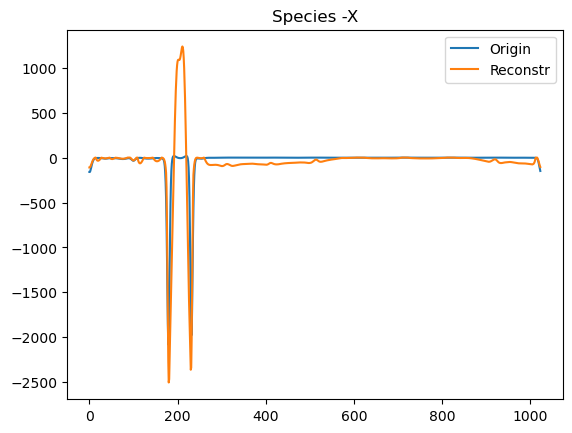

In [10]:
plot_compare(prod_old,prod_new,species=0)

## Co variance

Orignial data
Maxima is 19.25 
 Minima is 0.00 
 (1024, 14)
Reconstructed data
Maxima is 18.59 
 Minima is -0.02 
 (1024, 14)
Error in reconstruction after retaining 4 vectors is 0.0038


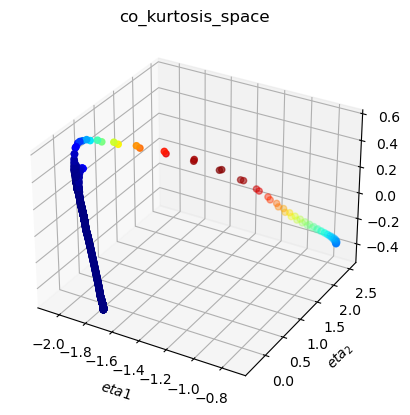

In [11]:
err,xold,xnew = transform_step(xrig)

In [12]:
prod_new,react_new = cantera_step(xnew,verbose=0) 
prod_old,react_old = cantera_step(xold)


  gas:

       temperature   1155 K
          pressure   4.2115e+05 Pa
           density   1.1228 kg/m^3
  mean mol. weight   25.602 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy        2.4462e+05        6.2629e+06  J
   internal energy       -1.3048e+05       -3.3404e+06  J
           entropy            8888.6        2.2757e+05  J/K
    Gibbs function       -1.0022e+07       -2.5658e+08  J
 heat capacity c_p            1311.8             33586  J/K
 heat capacity c_v            987.09             25271  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                H2         0.0085544           0.10864           -18.657
                O2           0.18498           0.14801           -27.449
                 O        0.00080484         0.0012879          -0.21083
 